# Chapter6 The Method of Godunov for Non–linear Systems

## expansion to 2 dimension

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA device: NVIDIA GeForce GTX 1660 SUPER


In [2]:
#Constant parameters
NUM_CELLS_X = 101
NUM_CELLS_Y = 101

X_DOMAIN = [0, 1]
Y_DOMAIN = [0, 1]
T_DOMAIN = [0, 0.5]
DX = (X_DOMAIN[1] - X_DOMAIN[0]) / NUM_CELLS_X
DY = (Y_DOMAIN[1] - Y_DOMAIN[0]) / NUM_CELLS_Y

CFL_COEFFICIENT = 0.8
GAMMA = 1.4
TOL = 1e-6

DIAMETER = 0.1

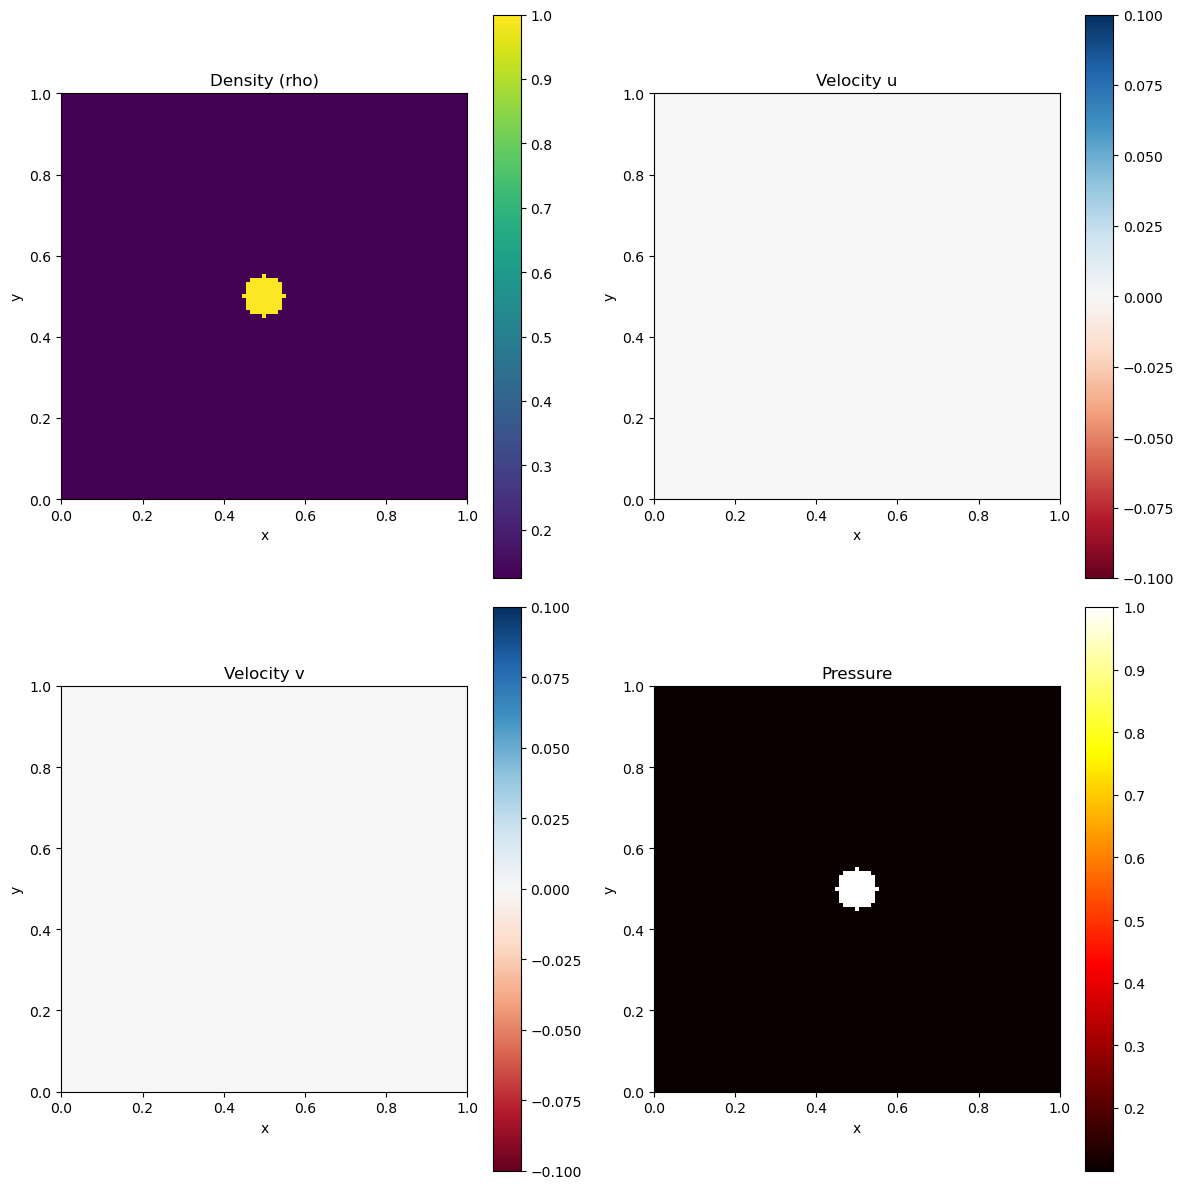

In [3]:
#Initial conditions - Explosion scenario
# +2 for cell boundary (ghost cells)
# Shape: (Ny+2, Nx+2, 4) - [rho, u, v, p]
CELL = torch.zeros((NUM_CELLS_Y + 2, NUM_CELLS_X + 2, 4), device=device)

# 중심 좌표 (도메인 중앙)
center_x = (X_DOMAIN[0] + X_DOMAIN[1]) / 2
center_y = (Y_DOMAIN[0] + Y_DOMAIN[1]) / 2
radius = DIAMETER / 2  # 반경

# 각 셀의 중심 좌표 계산 (ghost cell 제외한 실제 셀만)
x_coords = torch.linspace(X_DOMAIN[0] + DX/2, X_DOMAIN[1] - DX/2, NUM_CELLS_X, device=device)
y_coords = torch.linspace(Y_DOMAIN[0] + DY/2, Y_DOMAIN[1] - DY/2, NUM_CELLS_Y, device=device)
X, Y = torch.meshgrid(x_coords, y_coords, indexing='xy')  # (Ny, Nx)

# 중심으로부터의 거리 계산
distances = torch.sqrt((X - center_x)**2 + (Y - center_y)**2)

# 폭발 영역 (반경 내부): 고압, 고밀도
explosion_mask = distances < radius

# 기본값 설정 (외부 영역) - ghost cell 포함 전체
CELL[:, :, 0] = 0.125  # rho (low density)
CELL[:, :, 1] = 0.0    # u
CELL[:, :, 2] = 0.0    # v
CELL[:, :, 3] = 0.1    # p (low pressure)

# 폭발 영역 설정 (고압, 고밀도) - 실제 셀만 (ghost cell 제외)
CELL[1:-1, 1:-1, 0][explosion_mask] = 1.0   # rho (high density)
CELL[1:-1, 1:-1, 1][explosion_mask] = 0.0    # u
CELL[1:-1, 1:-1, 2][explosion_mask] = 0.0    # v
CELL[1:-1, 1:-1, 3][explosion_mask] = 1.0    # p (high pressure)

#Plot initial conditions as 2D image
rho_values = CELL[1:-1, 1:-1, 0].cpu().numpy()
u_values = CELL[1:-1, 1:-1, 1].cpu().numpy()
v_values = CELL[1:-1, 1:-1, 2].cpu().numpy()
p_values = CELL[1:-1, 1:-1, 3].cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im1 = axes[0, 0].imshow(rho_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='viridis')
axes[0, 0].set_title('Density (rho)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(u_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='RdBu')
axes[0, 1].set_title('Velocity u')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 0].imshow(v_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='RdBu')
axes[1, 0].set_title('Velocity v')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(p_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='hot')
axes[1, 1].set_title('Pressure')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()


In [4]:
#vectorized solution of local_riemann_problem

#local reimann problem에서 characteristic wave의 경계에서의 유속 변화량 f를 구함. + vectorized version
def compute_f_and_df(p, W_L, W_R):
    """
    W_L, W_R: (..., 4) - [rho, u, v, p] primitive variables
    p: (...,) - pressure guess
    """
    left_rho = W_L[..., 0]
    left_p = W_L[..., 3]
    right_rho = W_R[..., 0]
    right_p = W_R[..., 3]
    
    Al = 2 / (GAMMA + 1) / left_rho
    Ar = 2 / (GAMMA + 1) / right_rho
    Bl = (GAMMA - 1) / (GAMMA + 1) * left_p
    Br = (GAMMA - 1) / (GAMMA + 1) * right_p
    al = torch.sqrt(GAMMA * left_p / left_rho)
    ar = torch.sqrt(GAMMA * right_p / right_rho)
    
    left_shock_cell = p > left_p
    right_shock_cell = p > right_p

    #left rarefaction wave
    fl = 2 * al / (GAMMA - 1) * ((p/left_p)**((GAMMA - 1)/(2 * GAMMA)) - 1)
    d_fl = 1 / left_rho / al * (p/left_p)**(-(GAMMA + 1)/(2 * GAMMA))
  
    #overide left shock wave
    fl[left_shock_cell] = ((p - left_p) * torch.sqrt(Al / (p + Bl)))[left_shock_cell]
    d_fl[left_shock_cell] = (torch.sqrt(Al / (Bl + p)) * (1 - 0.5 * (p - left_p) / (Bl + p)))[left_shock_cell]


    #right rarefaction wave
    fr = 2 * ar / (GAMMA - 1) * ((p/right_p)**((GAMMA - 1)/(2 * GAMMA)) - 1)
    d_fr = 1 / right_rho / ar * (p/right_p)**(-(GAMMA + 1)/(2 * GAMMA))
    
    #overide right shock wave
    fr[right_shock_cell] = ((p - right_p)* torch.sqrt(Ar / (p + Br)))[right_shock_cell]
    d_fr[right_shock_cell] = (torch.sqrt(Ar / (Br + p)) * (1 - 0.5 * (p - right_p) / (Br + p)))[right_shock_cell]

    return fl, d_fl, fr, d_fr

#vectorized version of solve_riemann_star_state
def solve_riemann_star_state(W_L, W_R, normal='x'):
    """
    Get the exact Riemann solution for the Euler equations.
    Newton-Raphson iterative procedure

    p(k)= p(k-1)- f(p(k-1)) / f'(p(k-1))

    W_L, W_R: (..., 4) - [rho, u, v, p] primitive variables
    normal: 'x' or 'y' - direction of the Riemann problem
    
    return value: p*, u* (or v*), rho*l, rho*r
    """
    # Extract variables from state
    left_rho = W_L[..., 0]
    left_p = W_L[..., 3]
    right_rho = W_R[..., 0]
    right_p = W_R[..., 3]
    
    # Select velocity component based on normal direction
    if normal == 'x':
        left_u = W_L[..., 1]  # u component
        right_u = W_R[..., 1]
    elif normal == 'y':
        left_u = W_L[..., 2]  # v component
        right_u = W_R[..., 2]
    else:
        raise ValueError("normal must be 'x' or 'y'")

    loop_count = 0

    # Initial guess for the pressure
    # Should be optimaized using Two–Rarefaction approximation, primitive variables, Two–Shock approximation.
    p = 0.5 * (left_p + right_p)
    while(True):
        loop_count += 1
        prev_p = p
        fl, d_fl, fr, d_fr = compute_f_and_df(p, W_L, W_R)

        f = fl + fr  + right_u - left_u
        df = d_fl + d_fr

        p = p - f / df
        #음압 방지.
        p = torch.clamp(p, min=torch.tensor(1e-12, device=p.device))
        #모든 셀에서 충족하면 종료.
        tol_tensor = torch.tensor(TOL, device=p.device)
        if(torch.all(2 * abs(p - prev_p) < tol_tensor * (p + prev_p)) or loop_count > 1000):
            break
    
    fl, d_fl, fr, d_fr = compute_f_and_df(p, W_L, W_R)
    u = 0.5 * (left_u + right_u + fr - fl)

    left_shock_cell = p > left_p
    right_shock_cell = p > right_p

    rho_l_star = left_rho * (p / left_p) ** (1 / GAMMA)
    rho_l_star[left_shock_cell] = (left_rho * (GAMMA * (p + left_p) - left_p + p) /
                                  (GAMMA * (p + left_p) - p + left_p))[left_shock_cell]

    rho_r_star = right_rho * (p / right_p) ** (1 / GAMMA)
    rho_r_star[right_shock_cell] = (right_rho * (GAMMA * (p + right_p) - right_p + p) /
                                  (GAMMA * (p + right_p) - p + right_p))[right_shock_cell]

    return p, u, rho_l_star, rho_r_star

In [5]:

def riemann_flux(W_L, W_R, normal='x'):
    """
    Solve local Riemann problem at s = 0 for all interfaces along one direction.
    Returns the flux at the interface.
    
    W_L, W_R: (..., 4) - [rho, u, v, p] primitive variables
    normal: 'x' or 'y' - direction of the Riemann problem
    Returns: (..., 4) - flux at the interface
    """
    # Extract variables from state
    left_rho = W_L[..., 0]
    left_p = W_L[..., 3]
    right_rho = W_R[..., 0]
    right_p = W_R[..., 3]
    
    # Select velocity component based on normal direction
    if normal == 'x':
        left_u = W_L[..., 1]  # u component
        right_u = W_R[..., 1]
        left_v = W_L[..., 2]  # v component (perpendicular)
        right_v = W_R[..., 2]
    elif normal == 'y':
        left_u = W_L[..., 2]  # v component
        right_u = W_R[..., 2]
        left_v = W_L[..., 1]  # u component (perpendicular)
        right_v = W_R[..., 1]
    else:
        raise ValueError("normal must be 'x' or 'y'")
    
    p_star, u_star, rho_l_star, rho_r_star = solve_riemann_star_state(W_L, W_R, normal=normal)

    # s = 0 for Godunov flux evaluation
    s = torch.zeros_like(p_star)

    # Initialize solution variables
    shape = left_rho.shape
    rho = torch.zeros_like(left_rho)
    u = torch.zeros_like(left_u)
    p = torch.zeros_like(left_p)

    # Contact side masks (s=0)
    left_contact = s < u_star
    right_contact = ~left_contact

    # Left side: rarefaction or shock
    left_rarefaction = p_star < left_p
    left_shock = ~left_rarefaction

    # Right side: rarefaction or shock
    right_rarefaction = p_star < right_p
    right_shock = ~right_rarefaction

    # -------- Left rarefaction --------
    if torch.any(left_contact & left_rarefaction):
        al = torch.sqrt(GAMMA * left_p / left_rho)
        s_hl = left_u - al

        # Region 1: left state
        mask_l1 = left_contact & left_rarefaction & (s < s_hl) 
        if torch.any(mask_l1):
            rho[mask_l1] = left_rho[mask_l1]
            u[mask_l1] = left_u[mask_l1]
            p[mask_l1] = left_p[mask_l1]

        # Region 2: star left
        al_star = al * (p_star / left_p) ** ((GAMMA - 1) / (2 * GAMMA))
        s_tl = u_star - al_star
        mask_l2 = left_contact & left_rarefaction & (s > s_tl)
        if torch.any(mask_l2):
            rho[mask_l2] = rho_l_star[mask_l2]
            u[mask_l2] = u_star[mask_l2]
            p[mask_l2] = p_star[mask_l2]

        # Region 3: inside fan
        mask_l3 = left_contact & left_rarefaction & ~(s < s_hl) & ~(s > s_tl)
        if torch.any(mask_l3):
            p[mask_l3] = left_p[mask_l3] * ((2 * al[mask_l3] + (GAMMA - 1) * (left_u[mask_l3] - s[mask_l3])) / (al[mask_l3] * (GAMMA + 1))) ** (2 * GAMMA / (GAMMA - 1))
            u[mask_l3] = 2 / (GAMMA + 1) * (al[mask_l3] + (GAMMA - 1) / 2 * left_u[mask_l3] + s[mask_l3])
            rho[mask_l3] = left_rho[mask_l3] * ((2 * al[mask_l3] + (GAMMA - 1) * (left_u[mask_l3] - s[mask_l3])) / (al[mask_l3] * (GAMMA + 1))) ** (2 / (GAMMA - 1))

    # -------- Left shock --------
    if torch.any(left_contact & left_shock):
        al = torch.sqrt(GAMMA * left_p / left_rho)
        s_l = left_u - al * torch.sqrt((GAMMA * (p_star + left_p) + p_star - left_p) / (2 * GAMMA * left_p))
        mask_ls = left_contact & left_shock & (s < s_l)
        if torch.any(mask_ls):
            rho[mask_ls] = left_rho[mask_ls]
            u[mask_ls] = left_u[mask_ls]
            p[mask_ls] = left_p[mask_ls]

        mask_ls2 = left_contact & left_shock & ~(s < s_l)
        if torch.any(mask_ls2):
            rho[mask_ls2] = rho_l_star[mask_ls2]
            u[mask_ls2] = u_star[mask_ls2]
            p[mask_ls2] = p_star[mask_ls2]

    # -------- Right rarefaction --------
    if torch.any(right_contact & right_rarefaction):
        ar = torch.sqrt(GAMMA * right_p / right_rho)
        s_hr = right_u + ar

        # Region 1: right state
        mask_r1 = right_contact & right_rarefaction & (s > s_hr)
        if torch.any(mask_r1):
            rho[mask_r1] = right_rho[mask_r1]
            u[mask_r1] = right_u[mask_r1]
            p[mask_r1] = right_p[mask_r1]

        # Region 2: star right
        ar_star = ar * (p_star / right_p) ** ((GAMMA - 1) / (2 * GAMMA))
        s_tr = u_star + ar_star
        mask_r2 = right_contact & right_rarefaction & (s < s_tr)
        if torch.any(mask_r2):
            rho[mask_r2] = rho_r_star[mask_r2]
            u[mask_r2] = u_star[mask_r2]
            p[mask_r2] = p_star[mask_r2]

        # Region 3: inside fan
        mask_r3 = right_contact & right_rarefaction & ~(s > s_hr) & ~(s < s_tr)
        if torch.any(mask_r3):
            p[mask_r3] = right_p[mask_r3] * ((2 * ar[mask_r3] + (GAMMA - 1) * (s[mask_r3] - right_u[mask_r3])) / (ar[mask_r3] * (GAMMA + 1))) ** (2 * GAMMA / (GAMMA - 1))
            u[mask_r3] = 2 / (GAMMA + 1) * (-ar[mask_r3] + (GAMMA - 1) / 2 * right_u[mask_r3] + s[mask_r3])
            rho[mask_r3] = right_rho[mask_r3] * ((2 * ar[mask_r3] + (GAMMA - 1) * (s[mask_r3] - right_u[mask_r3])) / (ar[mask_r3] * (GAMMA + 1))) ** (2 / (GAMMA - 1))

    # -------- Right shock --------
    if torch.any(right_contact & right_shock):
        ar = torch.sqrt(GAMMA * right_p / right_rho)
        s_r = right_u + ar * torch.sqrt((GAMMA * (p_star + right_p) + p_star - right_p) / (2 * GAMMA * right_p))
        mask_rs = right_contact & right_shock & (s > s_r)
        if torch.any(mask_rs):
            rho[mask_rs] = right_rho[mask_rs]
            u[mask_rs] = right_u[mask_rs]
            p[mask_rs] = right_p[mask_rs]

        mask_rs2 = right_contact & right_shock & ~(s > s_r)
        if torch.any(mask_rs2):
            rho[mask_rs2] = rho_r_star[mask_rs2]
            u[mask_rs2] = u_star[mask_rs2]
            p[mask_rs2] = p_star[mask_rs2]

    # Calculate flux
    v = torch.zeros_like(left_v)
    v[left_contact] = left_v[left_contact]
    v[right_contact] = right_v[right_contact]
    E = p / (GAMMA - 1) + 0.5 * rho * (u**2 + v**2)
    
    flux = torch.zeros((*shape, 4), device=rho.device)
    flux[..., 0] = rho * u                    # F_rho
    flux[..., 3] = u * (E + p)                # F_E

    if normal == 'x':
        flux[..., 1] = rho * u**2 + p             # F_rhou
        flux[..., 2] = rho * u * v                # F_rhov
    else:  # normal == 'y'
        flux[..., 1] = rho * v * u                # G_rhou
        flux[..., 2] = rho * u**2 + p             # G_rhov (u is v in y-direction)
    
    return flux


In [6]:
def cal_dt(CELL):
    """
    CELL: (Ny+2, Nx+2, 4) - [rho, u, v, p]
    """
    a = torch.sqrt(GAMMA * CELL[:, :, 3] / CELL[:, :, 0])  # sound speed
    u = CELL[:, :, 1]  # x-velocity
    v = CELL[:, :, 2]  # y-velocity
    u_max = torch.max(u.abs() + a)
    v_max = torch.max(v.abs() + a)
    dt_x = CFL_COEFFICIENT * DX / u_max
    dt_y = CFL_COEFFICIENT * DY / v_max
    return torch.min(dt_x, dt_y)

In [7]:
def W_to_U(W):
    rho = W[:, :, 0]
    u = W[:, :, 1]
    v = W[:, :, 2]
    p = W[:, :, 3]
    E = p / (GAMMA - 1) + 0.5 * rho * (u**2 + v**2)
    return torch.stack([rho, u * rho, v * rho, E], dim=2)

def U_to_W(U):
    rho = torch.clamp(U[:, :, 0], min=1e-10)
    u = U[:, :, 1] / rho
    v = U[:, :, 2] / rho
    E = U[:, :, 3]
    p = torch.clamp(torch.tensor((GAMMA - 1) * (E - 0.5 * rho * (u**2 + v**2)), device=U.device), min=1e-10)
    return torch.stack([rho, u, v, p], dim=2)


In [8]:
def update(DX, DY, CELL):
    """
    2D Euler equations update using dimensional splitting.
    CELL: (Ny+2, Nx+2, 4) - [rho, u, v, p] primitive variables (with ghost cells)
    """
    dt = cal_dt(CELL).item()
    
    # X-direction sweep: solve Riemann problems along x-direction for each y
    flux_x = riemann_flux(CELL[:, :-1, :], CELL[:, 1:, :], normal='x')  # (Ny+2, Nx+1, 4) - directly returns flux
    
    U_cell = W_to_U(CELL[:, 1:-1, :])
    
    # X-direction update
    U_new = U_cell + dt/DX * (flux_x[:, :-1, :] - flux_x[:, 1:, :])  # (Ny, Nx - 2, 4)
    
    # Convert back to primitive
    CELL[:, 1:-1, :] = U_to_W(U_new)
    
    # Apply boundary conditions in x-direction
    CELL[:, 0, :] = CELL[:, 1, :]
    CELL[:, -1, :] = CELL[:, -2, :]
    
    # Y-direction sweep: solve Riemann problems along y-direction for each x
    flux_y = riemann_flux(CELL[:-1, :, :], CELL[1:, :, :], normal='y')  # (Ny+1, Nx+2, 4) - directly returns flux
    
    # Update in y-direction
    U_cell = W_to_U(CELL[1:-1, :, :])
    
    # Y-direction update
    U_new = U_cell + dt/DY * (flux_y[:-1, :, :] - flux_y[1:, :, :])  # (Ny - 2, Nx, 4)
    
    # Convert back to primitive
    rho_new = torch.clamp(U_new[:, :, 0], min=1e-10)  # 음수 밀도 방지
    u_new = U_new[:, :, 1] / rho_new
    v_new = U_new[:, :, 2] / rho_new
    E_new = U_new[:, :, 3]
    p_new = (GAMMA - 1) * (E_new - 0.5 * rho_new * (u_new**2 + v_new**2))
    p_new = torch.clamp(p_new, min=1e-10)  # 음수 압력 방지
    
    # Final update
    CELL[1:-1, :, :] = U_to_W(U_new)
    
    # Apply boundary conditions in y-direction
    CELL[0] = CELL[1]
    CELL[-1] = CELL[-2]
    
    return CELL, dt

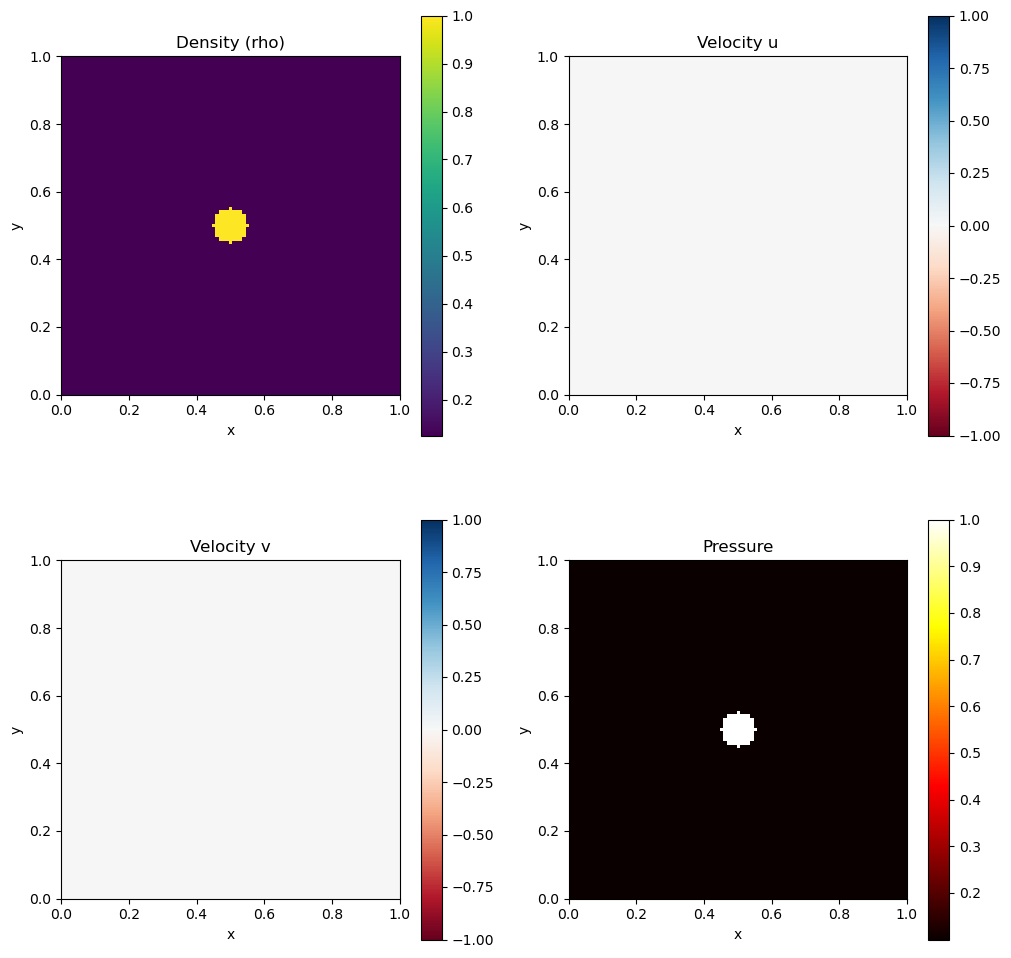

In [9]:
# Setup figure and axis for 2D visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Initial plot
rho_values = CELL[1:-1, 1:-1, 0].cpu().numpy()
u_values = CELL[1:-1, 1:-1, 1].cpu().numpy()
v_values = CELL[1:-1, 1:-1, 2].cpu().numpy()
p_values = CELL[1:-1, 1:-1, 3].cpu().numpy()

# Set a wider, symmetric velocity range based on initial max speed
max_speed = max(np.abs(u_values).max(), np.abs(v_values).max())
vel_limit = max(1.0, 2.0 * max_speed)

im1 = axes[0, 0].imshow(rho_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='viridis', animated=True)
axes[0, 0].set_title('Density (rho)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(u_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='RdBu', vmin=-vel_limit, vmax=vel_limit, animated=True)
axes[0, 1].set_title('Velocity u')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 0].imshow(v_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='RdBu', vmin=-vel_limit, vmax=vel_limit, animated=True)
axes[1, 0].set_title('Velocity v')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(p_values, origin='lower', extent=[X_DOMAIN[0], X_DOMAIN[1], Y_DOMAIN[0], Y_DOMAIN[1]], cmap='hot', animated=True)
axes[1, 1].set_title('Pressure')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 1])

# Animation parameters
TOTAL_T = T_DOMAIN[1] - T_DOMAIN[0]
t = 0.0

# Animation function
def animate(frame):
    global CELL, t, im1, im2, im3, im4

    CELL, dt = update(DX, DY, CELL)
    t = t + dt

    # Update images (GPU에서 CPU로 이동)
    rho_values = CELL[1:-1, 1:-1, 0].cpu().numpy()
    u_values = CELL[1:-1, 1:-1, 1].cpu().numpy()
    v_values = CELL[1:-1, 1:-1, 2].cpu().numpy()
    p_values = CELL[1:-1, 1:-1, 3].cpu().numpy()
    
    im1.set_array(rho_values)
    im2.set_array(u_values)
    im3.set_array(v_values)
    im4.set_array(p_values)

    # Update title
    fig.suptitle(f'Solution at t = {t:.3f}', fontsize=14)
    clear_output(wait=True)
    display(fig)
    
    return [im1, im2, im3, im4]

In [10]:
def frame_generator():
    global t
    while t < T_DOMAIN[1]:
        yield None


# Create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=frame_generator(),
    interval=50,
    blit=False,
    cache_frame_data=False
)

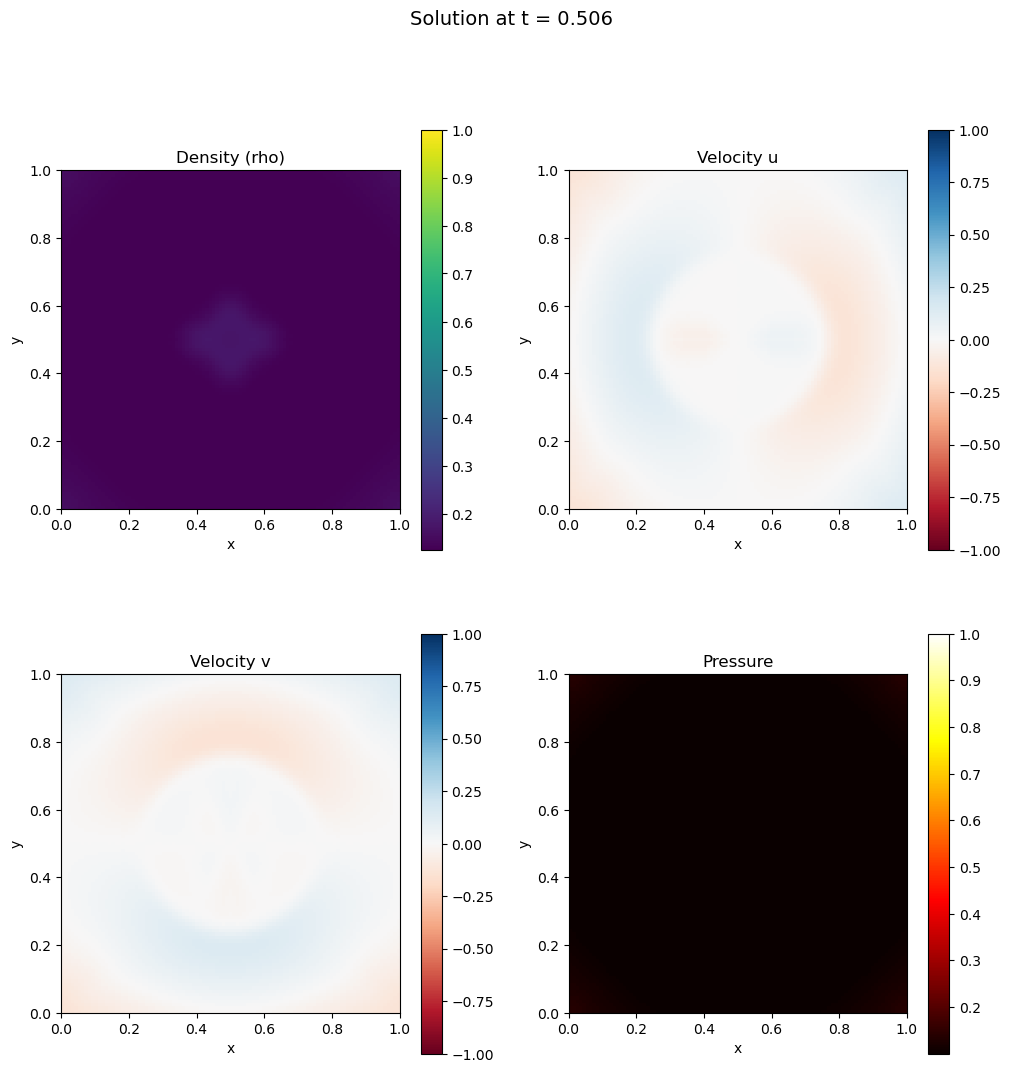

In [11]:
anim.save("Godunov_Euler_eq_2d.mp4", writer=animation.FFMpegWriter(fps=25))